In [1]:
from PIL import Image


image_path = "/kaggle/input/hc18-split/training_mask/000_HC_Annotation.png"  
image_notmask = "/kaggle/input/hc18-split/training_set/000_HC.png"
img = Image.open(image_path)  
img_notmsak = Image.open(image_notmask)
print(img.getbands())
print(img_notmsak.getbands())

('R', 'G', 'B')
('L',)


In [2]:
import os
import pandas as pd
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
class HC18_SEGMENT(Dataset):
    def __init__(self, image_files_x,image_files_y,transformation_x,transformation_y):
        self.image_files_x = image_files_x
        self.image_files_y = image_files_y
        self.trans_x = transformation_x
        self.trans_y = transformation_y
        self.location_x = []
        self.location_y = []
        for file in os.listdir(image_files_x):
            if file.endswith(".png"):
                locac = os.path.join(image_files_x,file)
                self.location_x.append(locac)
        for file in os.listdir(image_files_y):
            if file.endswith(".png"):
                locac = os.path.join(image_files_y,file)
                self.location_y.append(locac)
    def __len__(self):
        return len(self.location_x)  
        
    def __getitem__(self,idx):
        x = self.location_x[idx]
        y = self.location_y[idx]

        x = Image.open(x).convert("RGB")
        y = Image.open(y).convert("L")
        x = self.trans_x(x)
        y = self.trans_y(y)

        return x, y
        

transformation_x = transforms.Compose([
    transforms.Pad(padding=10, fill=0, padding_mode='constant'),
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

transformation_y = transforms.Compose([
    transforms.Pad(padding=10, fill=0, padding_mode='constant'),  
    transforms.Resize((224, 224)),  
    transforms.ToTensor() 
])

In [3]:
data_set_hc18 = HC18_SEGMENT("/kaggle/input/hc18-split/training_set","/kaggle/input/hc18-split/training_mask",transformation_x,transformation_y)

dataloader = DataLoader(data_set_hc18, batch_size=32, shuffle=True)
sample,label = next(iter(dataloader))
print(sample.shape)  
print(label.shape) 

torch.Size([32, 3, 224, 224])
torch.Size([32, 1, 224, 224])


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        
        features = init_features
        
        self.encoder1 = UNet._block(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.encoder2 = UNet._block(features, features*2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.encoder3 = UNet._block(features*2, features*4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features*4, features*8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        self.bottleneck = UNet._block(features*8, features*16)
        
        self.upconv4 = nn.ConvTranspose2d(features*16, features*8, kernel_size=2, stride=2)  
        self.decoder4 = UNet._block(features*16, features*8)
        self.upconv3 = nn.ConvTranspose2d(features*8, features*4, kernel_size=2, stride=2) 
        self.decoder3 = UNet._block(features*8, features*4)
        self.upconv2 = nn.ConvTranspose2d(features*4, features*2, kernel_size=2, stride=2)  
        self.decoder2 = UNet._block(features*4, features*2)
        self.upconv1 = nn.ConvTranspose2d(features*2, features, kernel_size=2, stride=2) 
        self.decoder1 = UNet._block(features*2, features)
        
        # Final layer
        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)
        
    def _block(in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)     
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))  
        enc4 = self.encoder4(self.pool3(enc3))  
        bottleneck = self.bottleneck(self.pool4(enc4))  
        

        dec4 = self.upconv4(bottleneck) 
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)       
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)      
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)      
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return torch.sigmoid(self.conv(dec1))


In [5]:
import torch.optim as optim
from tqdm import tqdm 
device = torch.device("cuda")
model = UNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=5e-5)
loss_mit = []
Epoch = 300
for epoch in range(Epoch):
    model.train()
    loop = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{Epoch}")
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_mit.append(loss.item())
        loop.set_postfix(loss=loss.item())

torch.save(model.state_dict(), "unet_model.pth")

Epoch 300/300: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s, loss=0.109]


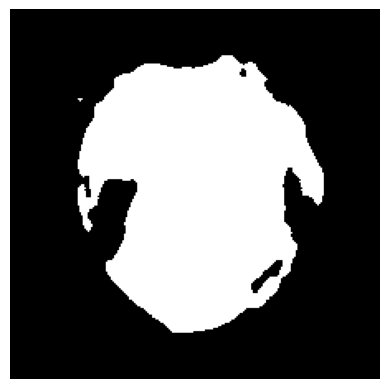

In [6]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
test_img = "/kaggle/input/hc18-split/training_set/000_HC.png"
image = Image.open(test_img).convert("RGB")
tensor = transformation_x(image).to(device)

tensor = tensor.unsqueeze(0) 

with torch.no_grad():
    output_batch = model(tensor)

output_batch = (output_batch > 0.5).float()

output_image = transforms.ToPILImage()(output_batch.squeeze(0)) 
plt.imshow(output_image.convert("L"), cmap='gray')
plt.axis('off')  
plt.show()

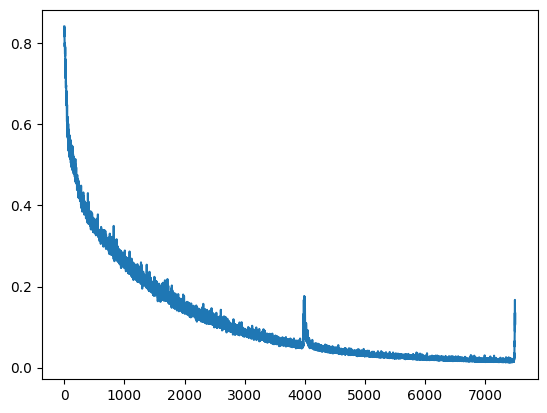

In [7]:
plt.plot(loss_mit)